In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import torch
from torch import nn
import torch.optim as optim

# Protocols for Strategic Agents: Mechanism Design

# 10.1 Introduction

Mechanism design is about to get agents to behave in desireable ways. E.g., to be truthful. An example is the second-price sealed-bid auction (or, Vickrey auction), which removes any incentive to underbid. By designing the system or protocols we can get agents to behave how we want. A regular auction wouldn't get the same outcome.

Auctions are coming in chapter 11, so for now we'll look at some other cases. Consider a transport network like this:

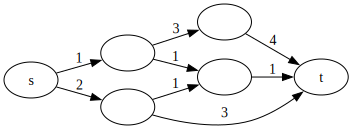

In [2]:
graph1 = Digraph()
graph1.attr(rankdir='LR')
graph1.node('S', 's')
graph1.node('A', '')
graph1.node('B', '')
graph1.node('C', '')
graph1.node('D', '')
graph1.node('T', 't')
graph1.edge('S', 'A', '1', color="black")
graph1.edge('S', 'C', '2', color="black")
graph1.edge('A', 'B', '3', color="black")
graph1.edge('A', 'D', '1', color="black")
graph1.edge('C', 'T', '3', color="black")
graph1.edge('C', 'D', '1', color="black")
graph1.edge('B', 'T', '4', color="black")
graph1.edge('D', 'T', '1', color="black")
display(graph1)

We want to route people through this network. Each edge belongs to a particular agent and has some true cost to use it, indicated above. However, the agents can lie about the cost of their edges. Is there a way around this?

## 10.2 Mechanism Design with unrestricted preferences

A useful place to start is to return to the idea of a Bayesian game. Bayesian games can be represented in a few ways (see chapter 6), the most useful here being the 'Epistemic type' way. Agents have some 'type', which is unknown to us, representing their individual preferences, and utility depends on both the type and actions of each player. When it comes to Mechanism Design we are providing both the actions and utility functions, under some restrictions, and trying to get some behaviour from the agents optimal to us. For instance, we might want our agents to choose the best combined option, rather than the best just for themselves. Key to Mechanism Design is the restriction on what we can do. In the book they introduce the idea of 'outcomes' which have utilities for the players, and all we can do is change mapping from actions to outcomes. This ends up being a restriction on our ability to change the utilities. Say I have two outcomes, $O_1$ and $O_2$, which will have an unknown utility to the players of ($a_1,b_1$) and ($a_2,b_2$). If we allow both players to take a single binary choice ($C$ or $D$) then we just need to define a function which maps each choice to the probability of the outcomes and we end up with this table (here let $p_{CC}$ mean the probability of outcome 1 given actions $CC$):

$
\begin{array}{c|cc}
\text{} & \text{C} & \text{D} \\
\hline
\text{C} & p_{CC}a_1+(1-p_{CC})a_2,p_{CC}b_1+(1-p_{CC})b_2 & p_{CD}a_1+(1-p_{CD})a_2,p_{CD}b_1+(1-p_{CD})b_2 \\
\text{D} & p_{DC}a_1+(1-p_{DC})a_2,p_{DC}b_1+(1-p_{DC})b_2 & p_{DD}a_1+(1-p_{DD})a_2,p_{DD}b_1+(1-p_{DD})b_2 \\
\end{array}
$

Say we want it so that if both players prefer option $O_1$ we want them to always get it. How can we go about doing that? One way is to set the probabilities above so that if both players go $C$ they get $O_1$ and otherwise they get $O_2$. I.e., $p_{CC}=1$, all others are 0. This gives us the table:

$
\begin{array}{c|cc}
\text{} & \text{C} & \text{D} \\
\hline
\text{C} & a_1,b_1 & a_2,b_2 \\
\text{D} & a_2,b_2 & a_2,b_2 \\
\end{array}
$

If both players prefer option 1 they will choose $C$. This is the heart of mechanism design. Another way to think about this is that we have our own utility function that depends on the success of the players. 

### 10.2.1 Implementation

A mechanism is a dominant implementation if it means that agents wouldn't ever deviate from their strategy, given any utility function. A further weaker notion is that no agent would deviate given the strategy of the other agent (i.e., at Nash equilibrium). We can tie this to social choice functions and say a mechanism implements a social choice function if it achieves the same outcomes in dominant strategies, or at nash equilibrium.

In the example above we have a dominant implementation. If I am the row player and I prefer $O_1$ to $O_2$ then I will always go $C$, otherwise $D$. Given my preferences the strategy won't change, and aligns with the aims of the designer. 

### 10.2.2 The revelation principle

One thing we might want is that agents truthfully reveal their type / preferences. It turns out that there is *always* a mechanism to do this *if* you have an existing mechanism with a dominant strategy implementation. The basic idea is quite simple. The new mechanism will only allow the agents to simply state their utilities. It will then plug those utilities into the first mechanism. Consider the example before:

$
\begin{array}{c|cc}
\text{} & \text{C} & \text{D} \\
\hline
\text{C} & a_1,b_1 & a_2,b_2 \\
\text{D} & a_2,b_2 & a_2,b_2 \\
\end{array}
$

Now instead of choosing $C$ or $D$ we just let agents tell us $a_1$ and $a_2$ etc. Or rather, we let them tell us their 'type'. We then plug those into the original mechanism to figure out what to do. Because the original mechanism is designed such that agents have dominant strategies there is no reason to lie about your utilities. Lying would imply that you might prefer to play $s^\prime$ instead of $s$, which can't be true. Essentially the original mechanism is designed to do the best thing it can with the information you provide it, so therefore you should provide it correct information.

This is very useful because if any successful mechanism can be implemented as a *truthful mechanism*, where the agents can only state preferences, then we have a much smaller space to search. Essentially the choice about what actions to allow the players goes away. We can just search the space of mechanisms which just allow the players to state their preferences, trying to find one where the optimal strategy is to be truthful and that meets our 'optimal' outcome requirements. 

**We just need to search the space of mechanisms where truth-telling is optimal to find dominant strategy implementations**

To build on the previous example, let's imagine we have 3 players $A$,$B$,$C$ and 3 outcomes $X$,$Y$,$Z$,with these utilities:

$
\begin{array}{c|cc}
\text{} & \text{X} & \text{Y} & \text{Z} \\
\hline
\text{A} & ax & ay & az \\
\text{B} & bx & by & bz\\
\text{C} & cx & cy & cz\\
\end{array}
$

Using the above we can restrict the actions of each agent to simply be a statement of their utilities, e.g., (1,2). Now our job is to decide on the probabilities of the outcomes given the actions of the agents. Of course, we can't just add up what the agents tell us, as they aren't going to necesarily tell us the truth. In fact, it ends up being impossible!

### 10.2.3 Impossibility of general, dominant-strategy implementation

A social choice function takes a set of preferences and turns it into an outcome. From Arrow's impossibility theorem we know it is impossible to make a social choice function which is Pareto Efficient (if all agents prefer A to B it must select A), Independent of Irrelevant Alternatives (If two preference profiles, each describing the preferences of all people, are identical with respect to A and B the algorithm should select A in the first only if it does in the second and vice-versa), and Non-Dictatorial (which means no single person ever solely determines the ordering). Likewise here there is no dominant-strategy truthful mechanism which is non-dictatorial. This does not hold for the weaker concepts of Nash equilibrium etc.

One way we can maybe explore mechanisms is with a neural network. We can have 1 network trying to maximize overall utility, and smaller networks for each player triyng to maximize their utility. Let's give it a go. 

In [3]:
class SmallNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, use_softmax=False):
        super().__init__()

        layers = [
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        ]

        if use_softmax:
            layers.append(nn.Softmax(dim=-1))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Epoch 1/10 | Avg reward: 0.5097
Epoch 2/10 | Avg reward: 0.5586
Epoch 3/10 | Avg reward: 0.6101
Epoch 4/10 | Avg reward: 0.6275
Epoch 5/10 | Avg reward: 0.6381
Epoch 6/10 | Avg reward: 0.6364
Epoch 7/10 | Avg reward: 0.6466
Epoch 8/10 | Avg reward: 0.6451
Epoch 9/10 | Avg reward: 0.6459
Epoch 10/10 | Avg reward: 0.6423


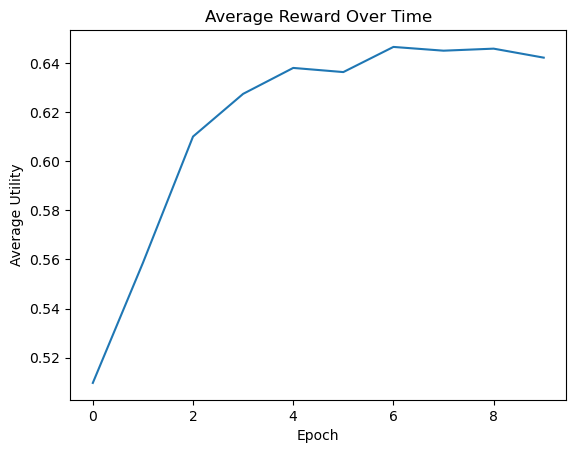

In [4]:
N, O = 3, 3
batch_size = 32
batches_per_epoch = 50
epochs = 10

players = nn.ModuleList([SmallNet(O, 100, O) for _ in range(N)])
mechanism = SmallNet(O*N, 100, O, use_softmax=True)

player_opts = [optim.Adam(players[p].parameters(), lr=1e-3) for p in range(N)]
mech_opt = optim.Adam(mechanism.parameters(), lr=1e-3)

reward_over_time = []

for epoch in range(epochs):
    epoch_avg = 0.0
    for batch in range(batches_per_epoch):
        utilities = torch.rand(batch_size, N, O)

        # --- Player updates (independent graphs per player) ---
        for p in range(N):
            player_opts[p].zero_grad()
            reports = [players[i](utilities[:, i]) for i in range(N)]
            joint_report = torch.cat(reports, dim=1)
            for param in mechanism.parameters():
                param.requires_grad_(False)
            decision = mechanism(joint_report)
            player_loss = -(utilities[:, p] * decision).sum(dim=1).mean()
            player_loss.backward()
            player_opts[p].step()
        
        for param in mechanism.parameters():
            param.requires_grad_(True)

        # --- Mechanism update ---
        mech_opt.zero_grad()
        reports_detached = [players[p](utilities[:, p]).detach() for p in range(N)]
        joint_report = torch.cat(reports_detached, dim=1)
        decision = mechanism(joint_report)
        expected_utility = torch.sum(utilities * decision.view(batch_size, 1, O), dim=2)
        mech_loss = -expected_utility.mean()
        mech_loss.backward()
        mech_opt.step()

        epoch_avg += expected_utility.mean().item()

    reward_over_time.append(epoch_avg / batches_per_epoch)
    print(f"Epoch {epoch+1}/{epochs} | Avg reward: {reward_over_time[-1]:.4f}")

plt.plot(reward_over_time)
plt.title("Average Reward Over Time")
plt.xlabel("Epoch")
plt.ylabel("Average Utility")
plt.show()

If we look at what the network predicts...

In [5]:
utilities = torch.rand(1, N, O)
reports = [players[i](utilities[:, i]) for i in range(N)]
joint_report = torch.cat(reports, dim=1)
decision = mechanism(joint_report)
print(utilities.detach().numpy().round(2))
print(decision.detach().numpy().round(2))

[[[0.82 0.29 0.15]
  [0.5  0.48 0.88]
  [0.71 0.09 0.9 ]]]
[[1. 0. 0.]]


Nice! Kinda working. And 0.66 is the theoretical best result so, good to see.